In [1]:
import rich
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import GEOparse
import scBTF
import anndata as ad
from sklearn.metrics import roc_auc_score, roc_curve

from scBTF import FactorizationSet

%config InlineBackend.figure_formats = ['png2x']
sc.logging.print_header()
sc.settings.njobs = 32
scBTF.__version__

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.0 scikit-learn==1.2.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


'0.1.21'

## 1. Load factorization result and save signatures

In [2]:
consensus_factorization = FactorizationSet.load('/home/dchafamo/scBTF/results/hgnc_hals_consensus_factorization.pkl')

In [ ]:
sf = consensus_factorization.sc_tensor.sample_features
sf.loc['H09_370','ebv_status'] = 'positive'
sf['sample_type'] = sf['condition'].astype(str) + sf['ebv_status'].astype(str).apply(lambda x:''if x=='na' else '_'+x)
sf['sample_type'] = sf['sample_type'].map({'HL_negative': 'HL EBV-', 'HL_positive': 'HL EBV+', 'RLN': 'RLN'})
sample_type_dict = sf.sample_type.to_dict()
rich.print(sf['sample_type'].value_counts())
consensus_factorization.save_rank_results(rank=24, plot_erichment_terms=False)

In [4]:
sigs = pd.read_csv('results/rank_24/rank_24_raw_gene_factor_loadings.csv', index_col=0).round(5)
sigs = sigs.reset_index()
sigs.columns = ['NAME'] + [f'factor_{c}' for c in sigs.columns[1:]]

In [5]:
sigs.head()

,NAME,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,...,factor_14,factor_15,factor_16,factor_17,factor_18,factor_19,factor_20,factor_21,factor_22,factor_23
0,OR4F5,0.00000,0.00000,0.12984,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.03453,0.00638,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,SAMD11,0.96849,0.05745,0.27222,0.15477,4.82854,0.01078,2.72803,0.05841,0.00000,...,0.67146,1.51618,0.19804,0.04804,0.02864,0.00000,0.00000,0.10206,0.44902,0.18043
2,NOC2L,2.55617,2.88497,6.09590,1.97227,3.49826,0.00000,1.85201,2.14631,1.67624,...,3.82446,2.73262,5.22132,3.03726,2.39136,3.67623,4.58159,3.76073,0.00000,3.07416
3,KLHL17,0.24589,0.44465,0.84461,0.52777,0.25140,0.00000,0.25064,0.52272,0.84816,...,0.90725,0.49945,1.45699,0.39089,0.09636,0.21243,0.36490,0.27940,0.64770,0.27449
4,PLEKHN1,0.00000,0.00000,0.40946,0.32488,0.00000,0.13868,0.00000,0.39378,1.19071,...,3.62338,1.03660,0.10062,0.39818,0.00000,0.02168,0.05708,0.00000,5.19923,0.48692


In [6]:
sigs.to_csv('results/cibersortx_sig_rank_24.csv', sep='\t', index=False)

## 2. Load bulk RNA seq data from GEO

In [ ]:
gse = GEOparse.get_GEO("GSE17920")
adata = ad.AnnData(
    X = gse.pivot_samples('VALUE').to_numpy().T, 
    obs = gse.phenotype_data, 
    var = gse.gpls['GPL570'].table.set_index('Gene Symbol'), 
    dtype=np.float32
)
adata = adata[:,adata.var_names.notnull()]
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e6)
adata

In [8]:
# Extract outcome currently encoded in the title of each run
adata.obs['Outcome'] = adata.obs.title.str.split(',').str[0]
true_y = (adata.obs.Outcome.values == 'class F').astype(int)

In [9]:
# Keep only genes in the signature
adata = adata[:, adata.var.index.isin(sigs.NAME.values)].copy()

In [10]:
# Export bulk RNA seq counts
gse17920 = pd.DataFrame(adata.X.T)
gse17920.index = adata.var.index
gse17920.columns = adata.obs.title
gse17920.reset_index(inplace=True)
gse17920.to_csv('results/gse17920_mixture.csv', sep='\t', index=False)
gse17920.head()

title,Gene Symbol,"class F, rep1","class F, rep2","class F, rep3","class F, rep4","class F, rep5","class F, rep6","class F, rep7","class F, rep8","class F, rep9",...,"class S, rep83","class S, rep84","class S, rep85","class S, rep86","class S, rep87","class S, rep88","class S, rep89","class S, rep90","class S, rep91","class S, rep92"
0,RFC2,26.796436,24.751907,32.999332,30.743372,26.008434,29.123476,29.040768,30.030312,31.065212,...,23.753267,24.299496,33.799416,24.964226,29.671886,26.364174,28.409908,28.041168,27.974667,25.683399
1,HSPA6,21.431583,31.514484,22.661987,24.089592,20.806276,35.896183,24.141985,19.352413,19.734989,...,19.187716,24.223879,17.341825,19.866463,18.673592,25.814857,23.839045,17.952969,16.458101,20.001413
2,PAX8,31.864033,33.140179,32.918568,32.051361,33.813740,35.097202,34.696381,35.308720,35.438690,...,36.223610,34.276638,33.674019,33.758049,34.134102,30.079294,32.983128,31.794847,35.818439,36.449669
3,GUCA1A,10.237633,10.512463,9.552687,9.853428,10.442687,10.212289,9.183747,10.735807,10.915388,...,13.762286,10.832906,10.564479,11.293114,10.296428,9.959812,10.078161,10.147864,10.934426,11.339190
4,THRA,20.065500,19.384764,17.504219,18.183491,18.450459,18.965004,17.964363,18.419449,19.864662,...,19.992901,20.310854,15.994090,18.926018,19.243198,19.832113,18.443647,20.970770,18.621193,19.753601


## Prognosis prediction via Gene set scoring 

In [29]:
def roc_plot(true_y, y_prob, title, ax):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob, drop_intermediate=False)
    with plt.rc_context({'figure.figsize': (3, 3)}):
        ax.plot(fpr, tpr, 'k-')
        ax.plot(np.arange(0,1.01,0.1),np.arange(0,1.01,0.1), 'r:')
        ax.set_xlim(-0.02,1.02)
        ax.set_ylim(-0.02,1.02)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{title} AUC: {roc_auc_score(true_y, y_prob).round(3)}')

In [ ]:
paper_TAM_sig = pd.read_csv('data/paper_tam_sig.txt', header=None)[0].values
sc.tl.score_genes(adata, gene_list=paper_TAM_sig, score_name='paper_TAM_sig')
ips = adata.obs['characteristics_ch1.10.international prognostic score (ips)'].values.astype(float)

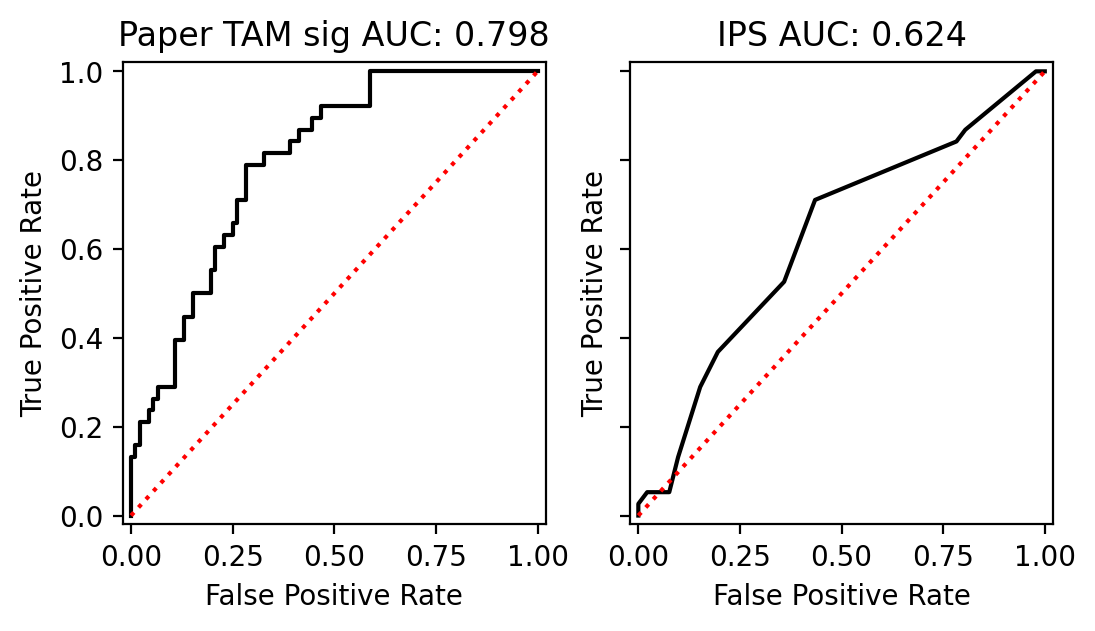

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
roc_plot(true_y, adata.obs.paper_TAM_sig.values, 'Paper TAM sig', ax=axs[0])
roc_plot(true_y, ips, 'IPS', ax=axs[1])
plt.show()

In [ ]:
for f in [3,5,8,15]:
    fac = pd.read_csv('results/rank_24/rank_24_gene_programs.csv', index_col=0)[str(f)]
    fac = fac[~fac.isna()].values
    sc.tl.score_genes(adata, gene_list=fac, score_name=f'F{f}_sig')

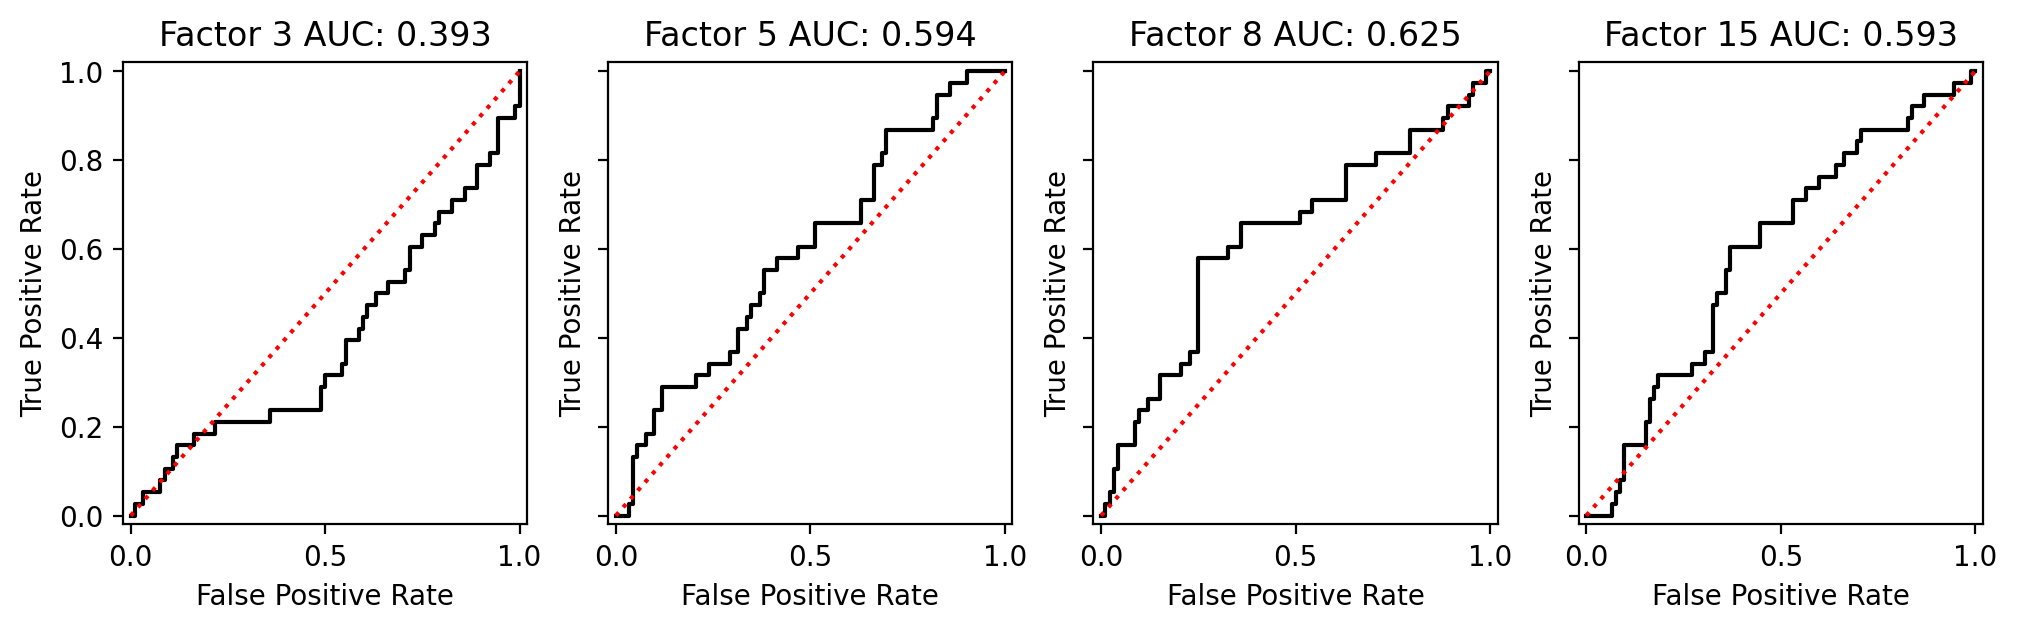

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i, f in enumerate([3, 5, 8, 15]):
    roc_plot(true_y, adata.obs[f'F{f}_sig'].values, f'Factor {f}', ax=axs[i])
plt.show()

## Prognosis prediction via Cibersortx

In [37]:
cibersortx_fracs = pd.read_csv('~/tensor_chl/results/CIBERSORTx_Adjusted.txt', sep='\t')

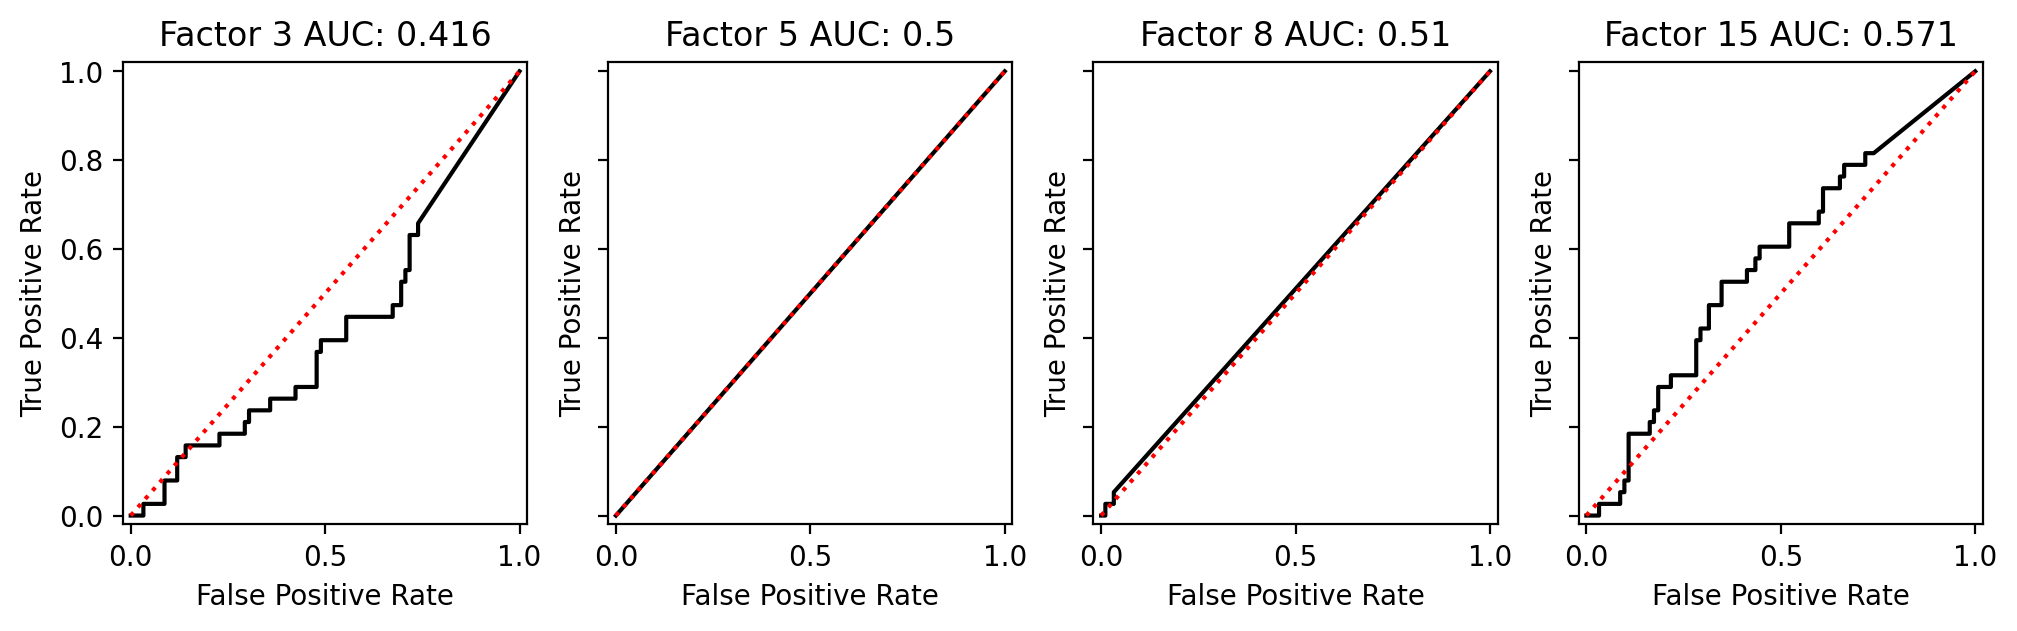

In [38]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i, f in enumerate([3, 5, 8, 15]):
    roc_plot(true_y, cibersortx_fracs[f'factor_{f}'].values, f'Factor {f}', ax=axs[i])
plt.show()

In [ ]:
All analysis for all 24 factors.

Can we predict relapse type? Refractory > Early > Late 

Correlation between IPS score or stage or age groups and factors?
